# VersionTranslator Timings

In [50]:
import time
import glob as gb
import subprocess
import shlex
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from python import regression_analysis
from itertools import product

from tqdm.notebook import trange, tqdm
from ipywidgets import HTML
from IPython.display import display
import multiprocessing

mpl.rcParams['figure.figsize'] = (16, 9)

In [24]:
PROG = r"""t = Time.now

include OpenStudio::Model
vt = OpenStudio::OSVersion::VersionTranslator.new
m = vt.loadModel("#OSM_PATH#").get

puts "VT: #{Time.now - t}"
puts "numModelObjects: #{m.objects.size}"

t = Time.now
m.save("tmp.osm", true)
puts "Model_save: #{Time.now - t}"

t = Time.now
ft = OpenStudio::EnergyPlus::ForwardTranslator.new
w = ft.translateModel(m);
puts "FT: #{Time.now - t}"
puts "numWorkspaceObjects: #{m.objects.size}"
t = Time.now
w.save("tmp.idf", true)
puts "Workspace_save: #{Time.now - t}"
"""

if "'" in PROG:
    raise ValueError("PROG can't have single quotes")
def time_vt_and_ft(arg, timeout_seconds=200):
    index_path, i = arg
    index = index_path[0]
    osm_path = index_path[1]

    prog = PROG.replace('#OSM_PATH#', osm_path)
    prog_one_line = ";".join([l.strip() for l in prog.splitlines() if l.strip()])
    cmd = f"openstudio -e '{prog_one_line}'"
    timings = {
        'Run': i,
        'VT': np.nan, 
        'numModelObjects': np.nan, 
        'Model_save': np.nan,
        'FT': np.nan,
        'numWorkspaceObjects': np.nan, 
        'Workspace_save': np.nan,
    }
    try:
        r = subprocess.run(shlex.split(cmd), check=True, stdout=subprocess.PIPE, timeout=timeout_seconds)
    except subprocess.CalledProcessError:
        print(f"Failed to run {cmd=}")
        return pd.Series(timings, name=index)
    except subprocess.TimeoutExpired:
        print(f"Timeout to run {cmd=}")
        return pd.Series(timings, name=index)
        
    lines = r.stdout.decode().splitlines()
    for line in lines:
        if ': ' in line:
            t, val = line.split(': ')
            if t in timings:
                timings[t] = float(val)
                    
    return pd.Series(timings, name=index)

In [38]:
df = regression_analysis.find_osm_test_versions()

In [20]:
len()

1490

In [27]:
pool = multiprocessing.Pool(processes=16)

runs = [x for x in product(df['path'].items(), range(1, 11)) if x[0][0] != 'scheduled_infiltration']

desc = '<h3>Timing OSMs</h3>'
label = HTML(desc)
display(label)
all_results = []
for result in tqdm(pool.imap_unordered(time_vt_and_ft, runs), total=len(runs)):
    all_results.append(result)

HTML(value='<h3>Timing OSMs</h3>')

  0%|          | 0/1490 [00:00<?, ?it/s]

In [87]:
df_timings = pd.concat(all_results, axis=1).T
df_timings.set_index('Run', append=True, inplace=True)

In [39]:
df = pd.concat([df, df_timings.set_index('Run', append=True).unstack(1)], axis=1)

In [70]:
nrows

6

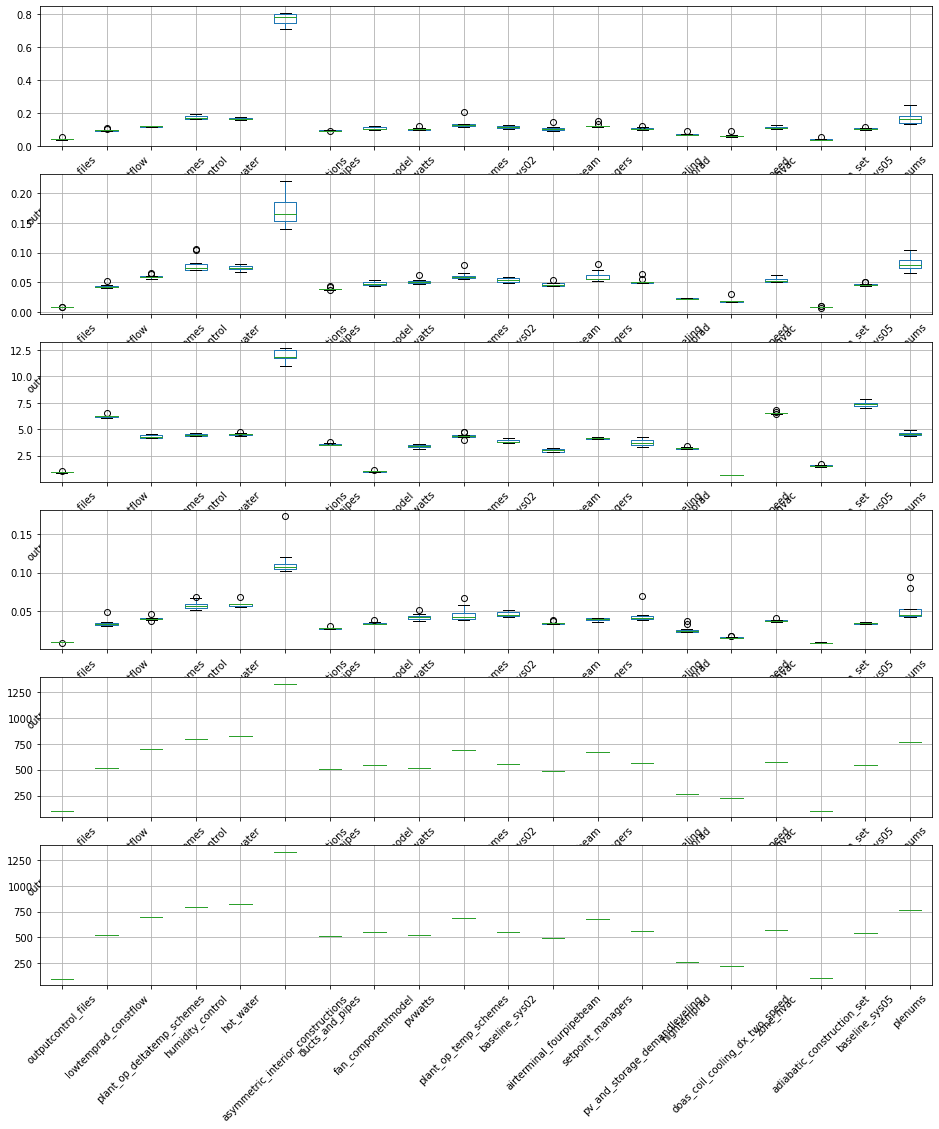

In [89]:
grouped = df_timings.unstack(1).T.sample(n=20, axis='columns').groupby(level=0, axis=0)

ncols = 1
nrows = int(np.ceil(grouped.ngroups/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows*3), sharey=False)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).boxplot(ax=ax, rot=45)

# ax.legend()
# fig.tight_layout()
plt.show()

In [90]:
df_timings.unstack(1).groupby(level=0, axis=1).mean()

,FT,Model_save,VT,Workspace_save,numModelObjects,numWorkspaceObjects
absorption_chillers,0.117590,0.060531,4.046365,0.041732,699.0,699.0
additional_props,0.096352,0.049212,3.127926,0.043473,518.0,518.0
adiabatic_construction_set,0.040195,0.008135,1.561322,0.008809,103.0,103.0
afn_single_zone_nv,0.037317,0.008214,2.360925,0.008699,106.0,106.0
air_chillers,0.119294,0.062211,4.202455,0.043015,639.0,639.0
...,...,...,...,...,...,...
zone_hvac_cooling_panel,0.046679,0.012032,0.805187,0.011482,151.0,151.0
zone_hvac_equipment_list,0.060187,0.017908,1.600437,0.016569,217.0,217.0
zone_mixing,0.048833,0.018330,4.391863,0.015252,194.0,194.0
zone_property_user_view_factors_by_surface_name,0.073391,0.027015,1.701060,0.024440,322.0,322.0


In [92]:
df_timings['Total_time'] = df_timings[['VT', 'Model_save', 'FT', 'Workspace_save']].sum(axis=1)

In [93]:
df_timings

VT  numModelObjects  \
                                     Run                               
additional_props                     5.0   3.054355            518.0   
                                     2.0   3.058007            518.0   
                                     6.0   3.061996            518.0   
                                     1.0   3.073921            518.0   
                                     3.0   3.098831            518.0   
...                                             ...              ...   
zoneventilation_windandstackopenarea 6.0   0.874075            162.0   
                                     7.0   0.844755            162.0   
                                     8.0   0.833378            162.0   
                                     9.0   0.848686            162.0   
                                     10.0  0.804825            162.0   

                                           Model_save        FT  \
                                     Run                          
additional_props                     5.0     0.049558  0.093807   
                                     2.0     0.045161  0.093138   
                                     6.0     0.046398  0.093808   
                                     1.0     0.054790  0.089378   
                                     3.0     0.045329  0.093465   
...                                               ...       ...   
zoneventilation_windandstackopenarea 6.0     0.007373  0.032311   
                                     7.0     0.007346  0.032962   
                                     8.0     0.007150  0.032594   
                                     9.0     0.007346  0.031848   
                                     10.0    0.007274  0.032351   

                                           numWorkspaceObjects  \
                                     Run                         
additional_props                     5.0                 518.0   
                                     2.0                 518.0   
                                     6.0                 518.0   
                                     1.0                 518.0   
                                     3.0                 518.0   
...                                                        ...   
zoneventilation_windandstackopenarea 6.0                 162.0   
                                     7.0                 162.0   
                                     8.0                 162.0   
                                     9.0                 162.0   
                                     10.0                162.0   

                                           Workspace_save  Total_time  
                                     Run                               
additional_props                     5.0         0.042444    3.240164  
                                     2.0         0.043045    3.239351  
                                     6.0         0.057032    3.259234  
                                     1.0         0.038001    3.256090  
                                     3.0         0.058719    3.296345  
...                                                   ...         ...  
zoneventilation_windandstackopenarea 6.0         0.007031    0.920790  
                                     7.0         0.007829    0.892892  
                                     8.0         0.007158    0.880280  
                                     9.0         0.007056    0.894936  
                                     10.0        0.008395    0.852845  

[1490 rows x 7 columns]

In [10]:
df['Total_time'] = df[['VT', 'Model_save', 'FT', 'Workspace_save']].sum(axis=1)

In [15]:
df['VT'].sort_values()

daylighting_devices                         0.400883
coilsystem_dxhx_desiccant_balancedflow      0.418158
heatpump_plantloop_eir                      0.443354
airterminal_inletsidemixer                  0.452054
unitary_vav_bypass_coiltypes                0.474408
                                             ...    
ems_scott                                   7.642802
baseline_sys10                              7.807904
baseline_sys09                              8.118380
asymmetric_interior_constructions          10.444529
scheduled_infiltration                    145.010704
Name: VT, Length: 150, dtype: float64

VT                   AxesSubplot(0.125,0.125;0.168478x0.755)
Model_save        AxesSubplot(0.327174,0.125;0.168478x0.755)
FT                AxesSubplot(0.529348,0.125;0.168478x0.755)
Workspace_save    AxesSubplot(0.731522,0.125;0.168478x0.755)
dtype: object

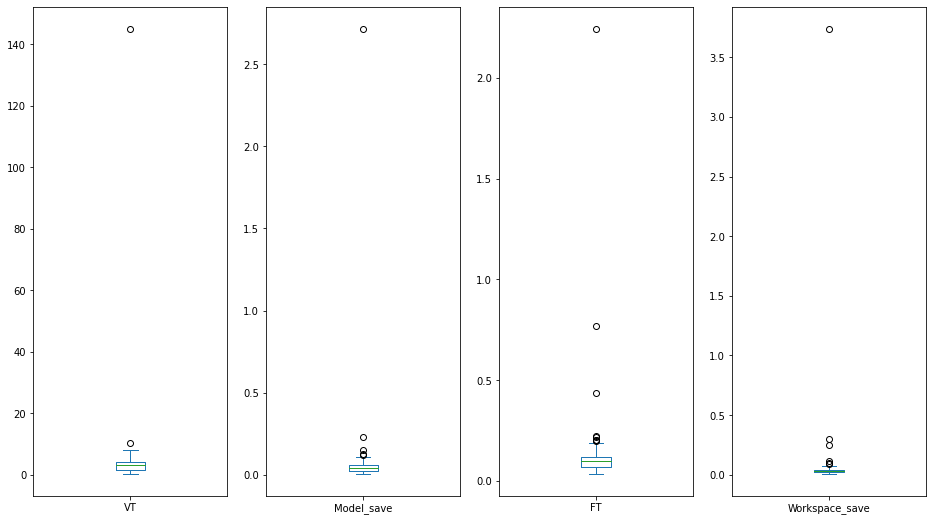

In [11]:
df[['VT', 'Model_save', 'FT', 'Workspace_save']].plot.box(figsize=(16, 9), subplots=True, sharey=False)

VT                   AxesSubplot(0.125,0.125;0.168478x0.755)
Model_save        AxesSubplot(0.327174,0.125;0.168478x0.755)
FT                AxesSubplot(0.529348,0.125;0.168478x0.755)
Workspace_save    AxesSubplot(0.731522,0.125;0.168478x0.755)
dtype: object

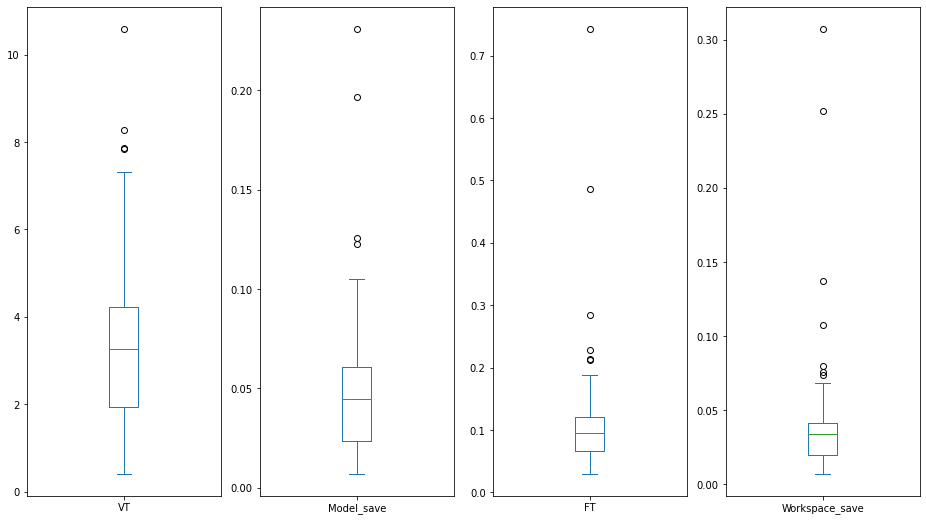

In [182]:
df.loc[[x for x in df.index if x != 'scheduled_infiltration'], ['VT', 'Model_save', 'FT', 'Workspace_save']].plot.box(figsize=(16, 9), subplots=True, sharey=False)

In [173]:
df.loc['scheduled_infiltration',
       ['VT', 'Model_save', 'FT', 'Workspace_save']] = [134.586689333, 2.637393409, 2.252753089,3.623018425]

In [179]:
df['Total_time'].nlargest(10)

scheduled_infiltration               143.099854
asymmetric_interior_constructions     11.634030
baseline_sys09                         8.527291
ems_scott                              8.244432
baseline_sys10                         8.161281
baseline_sys07                         8.063089
evaporative_cooling                    7.646670
fan_on_off                             7.586972
dist_ht_cl                             7.374627
baseline_sys05                         7.141332
Name: Total_time, dtype: float64